In [ ]:
#!pip install transformers
#!pip install torch          # For PyTorch
#!pip install tensorflow     # For TensorFlow
#!pip install numpy
#!pip install pandas


In [3]:
import transformers
import torch
import tensorflow as tf
import numpy as np
import pandas as pd

In [ ]:
from transformers import RobertaModel, RobertaTokenizer

tokenizer = RobertaTokenizer.from_pretrained('pdelobelle/robbert-v2-dutch-base')
model = RobertaModel.from_pretrained('pdelobelle/robbert-v2-dutch-base')


In [12]:
import pandas as pd

simlex = pd.read_csv('SimLex-999-Dutch-final.txt', sep='\t')


### Code for getting layer-wise similarity, all layers, including subtokenized words:

In [13]:
from transformers import BertModel, BertTokenizer
import torch
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr

def get_word_embedding(word, layer_nums):
    # Tokenize the word into subtokens and add special tokens [CLS] and [SEP]
    subtokens = [tokenizer.cls_token] + tokenizer.tokenize(word) + [tokenizer.sep_token]
    # Convert subtokens to input IDs
    input_ids = tokenizer.convert_tokens_to_ids(subtokens)
    # Wrap it in a tensor and add an extra batch dimension
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    # Make sure the model does not compute gradients
    with torch.no_grad():
        # Get the model outputs
        outputs = model(input_ids, output_hidden_states=True)
    # Check if layer_nums is a list or a single integer
    if isinstance(layer_nums, int):
        layer_nums = [layer_nums]
    # Use the hidden state from the specified layers as word embedding
    embeddings = [outputs.hidden_states[i] for i in layer_nums]
    # Average the embeddings from the specified layers
    averaged_embedding = torch.mean(torch.stack(embeddings), dim=0)
    # Ignore the first and the last token ([CLS] and [SEP])
    averaged_embedding = averaged_embedding[0, 1:-1]
    # Get the mean of the subtoken vectors to get the word vector
    word_embedding = torch.mean(averaged_embedding, dim=0)
    # Convert tensor to a numpy array
    word_embedding = word_embedding.numpy()
    return word_embedding


def calculate_similarity(word1, word2, layer_nums):
    word1_embedding = get_word_embedding(word1, layer_nums)
    word2_embedding = get_word_embedding(word2, layer_nums)
    similarity = 1 - cosine(word1_embedding, word2_embedding)
    return similarity

# Specify the layers you want to combine
layer_nums = [1, 12]

spearman_results = []  # A list to store the Spearman correlations

# Calculate the Spearman correlation for each layer and each frequency group
for layer_num in range(13):  # For RobBERT base models, there are 13 layers including the output layer
    similarity_scores = []  # Initialize similarity_scores in each iteration

    for _, row in simlex.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        similarity = calculate_similarity(word1, word2, layer_num)
        similarity_scores.append(similarity)

    simlex[f'predicted_similarity_layer_{layer_num}'] = similarity_scores
    correlation, _ = spearmanr(simlex['SimLex999'], simlex[f'predicted_similarity_layer_{layer_num}'])
    spearman_results.append(correlation)
    print(f'Layer {layer_num} - Spearman correlation: {correlation:.3f}')


Layer 0 - Spearman correlation: 0.207
Layer 1 - Spearman correlation: 0.179
Layer 2 - Spearman correlation: 0.124
Layer 3 - Spearman correlation: 0.130
Layer 4 - Spearman correlation: 0.164
Layer 5 - Spearman correlation: 0.187
Layer 6 - Spearman correlation: 0.168
Layer 7 - Spearman correlation: 0.162
Layer 8 - Spearman correlation: 0.160
Layer 9 - Spearman correlation: 0.167
Layer 10 - Spearman correlation: 0.127
Layer 11 - Spearman correlation: 0.082
Layer 12 - Spearman correlation: 0.084


#### Visualize in blue colour scheme

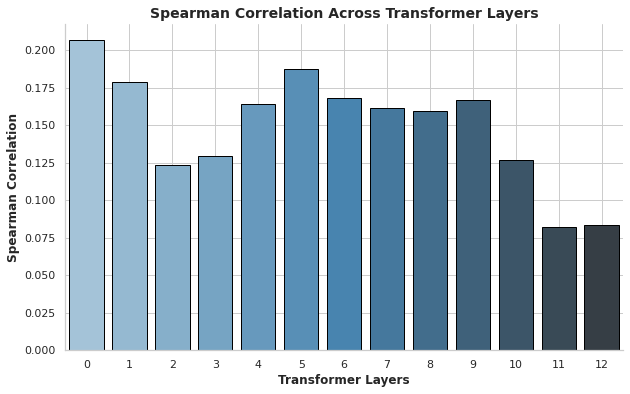

In [15]:
import torch
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x=list(range(13)), y=spearman_results, palette="Blues_d", ax=ax, edgecolor='black')
ax.set_title('Spearman Correlation Across Transformer Layers', fontsize=14, fontweight='bold')
ax.set_xlabel('Transformer Layers', fontsize=12, fontweight='bold')
ax.set_ylabel('Spearman Correlation', fontsize=12, fontweight='bold')
ax.grid(True)
sns.despine()
plt.show()

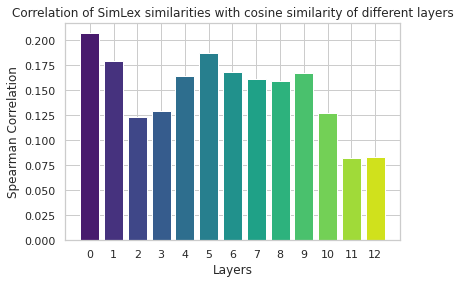

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

correlations = []

# Collect the correlations for each layer
for layer_num in range(13):  # For RobBERT base models, there are 13 layers including the output layer
    correlation, _ = spearmanr(simlex['SimLex999'], simlex[f'predicted_similarity_layer_{layer_num}'])
    correlations.append(correlation)

# Create a figure and axis
fig, ax = plt.subplots()

# Set colors for the layers
colors = sns.color_palette("viridis", len(correlations))

# Bar plot for the layers
ax.bar(range(len(correlations)), correlations, color=colors)

# Set the title and labels
ax.set_title('Correlation of SimLex similarities with cosine similarity of different layers')
ax.set_xlabel('Layers')
ax.set_ylabel('Spearman Correlation')

# Set the xticks to be the layer numbers
ax.set_xticks(range(len(correlations)))
ax.set_xticklabels(range(len(correlations)))

# Show the plot
plt.show()


#### Code to get predicted similarity (including subtokenized words) for a specific combination of layers:

In [17]:
def calculate_similarity(word1, word2, layer_nums):
    word1_embedding = get_word_embedding(word1, layer_nums)
    word2_embedding = get_word_embedding(word2, layer_nums)
    similarity = 1 - cosine(word1_embedding, word2_embedding)
    return similarity

# Specify the layers you want to combine
layer_nums = [0, 5]

similarity_scores = []
for _, row in simlex.iterrows():
    word1 = row['word1']
    word2 = row['word2']
    similarity = calculate_similarity(word1, word2, layer_nums)
    similarity_scores.append(similarity)

simlex['predicted_similarity'] = similarity_scores

# Assuming 'SimLex999' column contains the true similarity scores
correlation, _ = spearmanr(simlex['SimLex999'], simlex['predicted_similarity'])
print(f'Layers {layer_nums} - Spearman correlation: {correlation:.3f}')


Layers [0, 5] - Spearman correlation: 0.247


#### Error analysis, for the layer combination specified in previous cell:

In [19]:
from sklearn.preprocessing import MinMaxScaler

# Create a scaler object that will scale values to range from 0 to 10
scaler = MinMaxScaler(feature_range=(0, 10))

# Fit the scaler on the predicted similarity scores and transform them
simlex['predicted_similarity_scaled'] = scaler.fit_transform(simlex[['predicted_similarity']])


In [21]:
# Compute absolute differences between predicted and actual scores
simlex['abs_diff'] = abs(simlex['SimLex999'] - simlex['predicted_similarity_scaled'])

# Sort by absolute differences
simlex_sorted = simlex.sort_values('abs_diff', ascending=False)

# Print out the word pairs with the largest differences
print(simlex_sorted[['word1', 'word2', 'SimLex999', 'predicted_similarity', 'predicted_similarity_scaled', 'abs_diff']].head(10))


# Print out the word pairs with the smallest differences
print(simlex_sorted[['word1', 'word2', 'SimLex999', 'predicted_similarity', 'predicted_similarity_scaled', 'abs_diff']].tail(10))


              word1         word2  SimLex999  predicted_similarity  \
795     aanmoedigen   ontmoedigen       1.71              0.890504   
22             vlug          snel       8.95              0.313093   
211     afwezigheid  aanwezigheid       2.54              0.878202   
855  desorganiseren   organiseren       2.68              0.872748   
477        aandacht     interesse       8.13              0.347057   
1              slim   intelligent       8.19              0.356813   
694          meisje  dienstmeisje       1.93              0.785701   
62         cruciaal    belangrijk       8.59              0.397066   
182       werkgever     werknemer       2.86              0.842186   
33             raar        vreemd       8.40              0.387726   

     predicted_similarity_scaled  abs_diff  
795                    10.000000  8.290000  
22                      0.868301  8.081699  
211                     9.805460  7.265460  
855                     9.719194  7.039194  
477 

#### POS-based analysis below:

In [22]:
# Group by POS and compute mean difference for each group
grouped = simlex.groupby('POS')['abs_diff'].mean()

# Print out the mean difference for each POS
print(grouped)

POS
A    2.308352
N    1.613524
V    1.719224
Name: abs_diff, dtype: float64


In [23]:
# Select the adjective pairs with the largest differences
adjectives = simlex[simlex['POS'] == 'A']
adjectives_sorted = adjectives.sort_values('abs_diff', ascending=False)
print('Adjective pairs with largest differences:')
print(adjectives_sorted[['word1', 'word2', 'SimLex999', 'predicted_similarity']].head(10))

# Select the noun pairs with the largest differences
nouns = simlex[simlex['POS'] == 'N']
nouns_sorted = nouns.sort_values('abs_diff', ascending=False)
print('\nNoun pairs with largest differences:')
print(nouns_sorted[['word1', 'word2', 'SimLex999', 'predicted_similarity']].head(10))

# Select the verb pairs with the largest differences
verbs = simlex[simlex['POS'] == 'V']
verbs_sorted = verbs.sort_values('abs_diff', ascending=False)
print('\nVerb pairs with largest differences:')
print(verbs_sorted[['word1', 'word2', 'SimLex999', 'predicted_similarity']].head(10))


Adjective pairs with largest differences:
           word1        word2  SimLex999  predicted_similarity
22          vlug         snel       8.95              0.313093
1           slim  intelligent       8.19              0.356813
62      cruciaal   belangrijk       8.59              0.397066
33          raar       vreemd       8.40              0.387726
87       angstig         bang       9.06              0.443877
13        slecht    vreselijk       7.53              0.347556
25   eigenaardig       vreemd       8.56              0.424983
23           dom        dwaas       6.57              0.311331
109        groot        enorm       7.53              0.374099
95       beladen        zwaar       7.33              0.378772

Noun pairs with largest differences:
              word1         word2  SimLex999  predicted_similarity
211     afwezigheid  aanwezigheid       2.54              0.878202
477        aandacht     interesse       8.13              0.347057
694          meisje  diens

In [24]:
pos_categories = ["A", "N", "V"]
for pos in pos_categories:
    pos_data = simlex[simlex['POS'] == pos]
    spearman_corr = pos_data['SimLex999'].corr(pos_data['predicted_similarity'], method='spearman')
    print(f"Spearman correlation for {pos}: {spearman_corr}")


Spearman correlation for A: 0.07650254043191729
Spearman correlation for N: 0.3191087147581901
Spearman correlation for V: 0.1363910693609344


In [25]:
simlex['abs_diff'] = abs(simlex['SimLex999'] - simlex['predicted_similarity'])
largest_diff = simlex.nlargest(10, 'abs_diff')
print(largest_diff)


           word1        word2  SimLex999 POS  predicted_similarity_layer_0  \
370         arts       dokter       9.28   N                      0.306086   
22          vlug         snel       8.95   A                      0.199788   
87       angstig         bang       9.06   A                      0.336690   
28     eenvoudig  gemakkelijk       9.04   A                      0.359508   
840    deelnemen      meedoen       8.90   V                      0.391600   
788      creëren        maken       8.76   V                      0.220548   
155     boosheid        woede       8.87   N                      0.407575   
62      cruciaal   belangrijk       8.59   A                      0.281145   
25   eigenaardig       vreemd       8.56   A                      0.371328   
236      bedrijf  onderneming       8.72   N                      0.579576   

     predicted_similarity_layer_1  predicted_similarity_layer_2  \
370                      0.479193                      0.514335   
22     

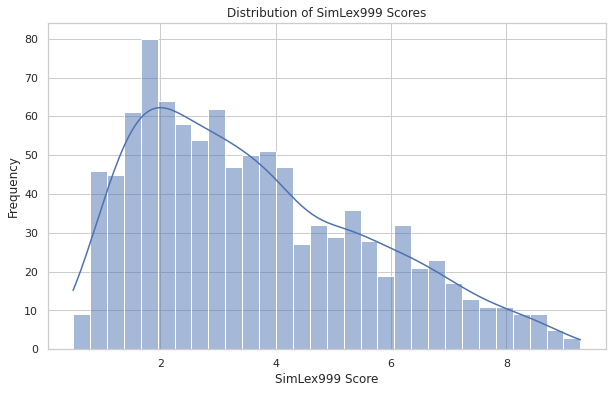

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram for SimLex999 scores
plt.figure(figsize=(10,6))
sns.histplot(data=simlex, x="SimLex999", bins=30, kde=True)
plt.title("Distribution of SimLex999 Scores")
plt.xlabel("SimLex999 Score")
plt.ylabel("Frequency")
plt.show()


#### Frequency category analysis using SUBTLEX-NL frequencies

In [27]:
# Lees de SUBTLEX-NL gegevens
subtlex_nl = pd.read_csv('SUBTLEX-NL-New.txt', sep='\t')

# Maak een woordenboek dat de frequentie van elk woord opslaat
word_frequencies = subtlex_nl.set_index('Word')['FREQcount'].to_dict()

# Nu kun je de frequenties uit dit woordenboek gebruiken in plaats van de willekeurige frequenties


In [28]:
# Add frequency data to SimLex999 DataFrame
simlex['frequency1'] = simlex['word1'].map(word_frequencies)
simlex['frequency2'] = simlex['word2'].map(word_frequencies)

# Calculate median frequency
median_freq = simlex[['frequency1', 'frequency2']].median().mean()

# Split into high frequency and low frequency subsets
simlex_high_freq = simlex[(simlex['frequency1'] > median_freq) & (simlex['frequency2'] > median_freq)]
simlex_low_freq = simlex[(simlex['frequency1'] <= median_freq) & (simlex['frequency2'] <= median_freq)]

# Specify the layers you want to combine
layer_nums = [1, 12]

for simlex_subset, freq in zip([simlex_high_freq, simlex_low_freq], ['high', 'low']):
    similarity_scores = []
    for _, row in simlex_subset.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        similarity = calculate_similarity(word1, word2, layer_nums)
        similarity_scores.append(similarity)

    simlex_subset['predicted_similarity'] = similarity_scores

    # Assuming 'SimLex999' column contains the true similarity scores
    correlation, _ = spearmanr(simlex_subset['SimLex999'], simlex_subset['predicted_similarity'])
    print(f'Layers {layer_nums} - Spearman correlation for {freq} frequency words: {correlation:.3f}')


/tmp/ipykernel_999649/761149108.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simlex_subset['predicted_similarity'] = similarity_scores


Layers [1, 12] - Spearman correlation for high frequency words: 0.146
Layers [1, 12] - Spearman correlation for low frequency words: 0.249


In [29]:
simlex_high_freq = simlex[(simlex['frequency1'] > median_freq) & (simlex['frequency2'] > median_freq)].copy()
simlex_low_freq = simlex[(simlex['frequency1'] <= median_freq) & (simlex['frequency2'] <= median_freq)].copy()


In [35]:
# Calculate the Spearman correlation for each layer and each frequency group
spearman_results_high = []
spearman_results_low = []

for layer_num in range(13):  # For BERT base models, there are 13 layers including the output layer
    similarity_scores_high = []
    similarity_scores_low = []

    for _, row in simlex_high_freq.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        similarity = calculate_similarity(word1, word2, [layer_num])
        similarity_scores_high.append(similarity)

    for _, row in simlex_low_freq.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        similarity = calculate_similarity(word1, word2, [layer_num])
        similarity_scores_low.append(similarity)
    

    simlex_high_freq['predicted_similarity'] = similarity_scores_high
    simlex_low_freq['predicted_similarity'] = similarity_scores_low

    correlation_high, _ = spearmanr(simlex_high_freq['SimLex999'], simlex_high_freq['predicted_similarity'])
    correlation_low, _ = spearmanr(simlex_low_freq['SimLex999'], simlex_low_freq['predicted_similarity'])
    

    spearman_results_high.append(correlation_high)
    spearman_results_low.append(correlation_low)
    
    print(f'Layer {layer_num} - Spearman correlation for high frequency words: {correlation_high:.3f}')
    print(f'Layer {layer_num} - Spearman correlation for low frequency words: {correlation_low:.3f}')


Layer 0 - Spearman correlation for high frequency words: 0.194
Layer 0 - Spearman correlation for low frequency words: 0.284
Layer 1 - Spearman correlation for high frequency words: 0.162
Layer 1 - Spearman correlation for low frequency words: 0.272
Layer 2 - Spearman correlation for high frequency words: 0.129
Layer 2 - Spearman correlation for low frequency words: 0.207
Layer 3 - Spearman correlation for high frequency words: 0.116
Layer 3 - Spearman correlation for low frequency words: 0.209
Layer 4 - Spearman correlation for high frequency words: 0.141
Layer 4 - Spearman correlation for low frequency words: 0.248
Layer 5 - Spearman correlation for high frequency words: 0.143
Layer 5 - Spearman correlation for low frequency words: 0.300
Layer 6 - Spearman correlation for high frequency words: 0.109
Layer 6 - Spearman correlation for low frequency words: 0.271
Layer 7 - Spearman correlation for high frequency words: 0.092
Layer 7 - Spearman correlation for low frequency words: 0.267


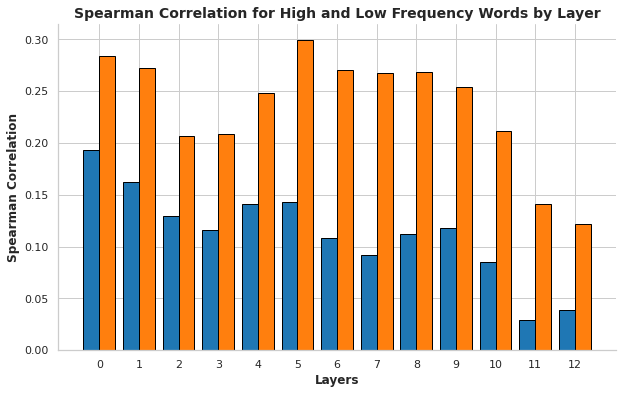

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns

# Improving plot aesthetics using Seaborn
sns.set(style="whitegrid")

x = np.arange(13)  # Positions for the bars
width = 0.4        # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot side-by-side bars
ax.bar(x - width/2, spearman_results_high, width, color="#1f77b4", edgecolor='black')
ax.bar(x + width/2, spearman_results_low, width, color="#ff7f0e", edgecolor='black')


# Adding title and labels
ax.set_title('Spearman Correlation for High and Low Frequency Words by Layer', fontsize=14, fontweight='bold')
ax.set_xlabel('Layers', fontsize=12, fontweight='bold')
ax.set_ylabel('Spearman Correlation', fontsize=12, fontweight='bold')

# Set the xticks to be the layer numbers
ax.set_xticks(range(13))
ax.set_xticklabels(range(13))

# Adding a grid
ax.grid(True)

# Remove top and right borders
sns.despine()

plt.show()


#### Checking model vocabulary

In [45]:
# Get the vocabulary used by the tokenizer
vocab = tokenizer.get_vocab()

# Create an empty set to store out-of-vocabulary (OOV) words
oov_words = set()

# Check each unique word in the SimLex-999 dataset
for word in pd.concat([simlex['word1'], simlex['word2']]).unique():
    if word not in vocab:
        oov_words.add(word)

print(f'There are {len(oov_words)} out-of-vocabulary words.')
print('Some examples are:', list(oov_words)[:10])

# Remove rows in simlex where either 'word1' or 'word2' is an OOV word
simlex_no_oov = simlex[~simlex['word1'].isin(oov_words) & ~simlex['word2'].isin(oov_words)]
print(f'There are {len(simlex_no_oov)} word pairs without OOV words.')


There are 556 out-of-vocabulary words.
Some examples are: ['intuïtie', 'elastisch', 'toevoegen', 'priester', 'planeet', 'bepalen', 'legioen', 'neef', 'discussie', 'vreselijk']
There are 318 word pairs without OOV words.


There are 556 out-of-vocabulary words.
Some examples are: ['intuïtie', 'elastisch', 'toevoegen', 'priester', 'planeet', 'bepalen', 'legioen', 'neef', 'discussie', 'vreselijk']
There are 318 word pairs without OOV words.


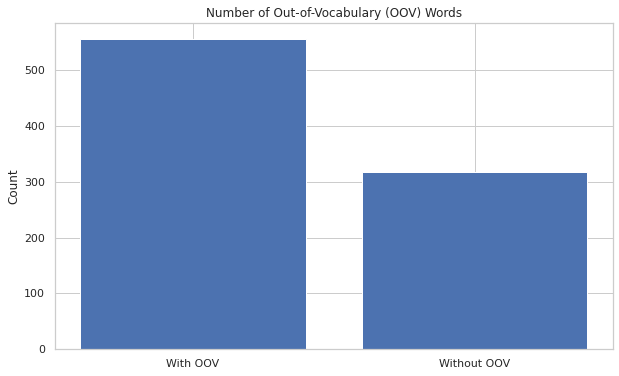

In [46]:
import matplotlib.pyplot as plt

# Get the vocabulary used by the tokenizer
vocab = tokenizer.get_vocab()

# Create an empty set to store out-of-vocabulary (OOV) words
oov_words = set()

# Check each unique word in the SimLex-999 dataset
for word in pd.concat([simlex['word1'], simlex['word2']]).unique():
    if word not in vocab:
        oov_words.add(word)

print(f'There are {len(oov_words)} out-of-vocabulary words.')
print('Some examples are:', list(oov_words)[:10])

# Remove rows in simlex where either 'word1' or 'word2' is an OOV word
simlex_no_oov = simlex[~simlex['word1'].isin(oov_words) & ~simlex['word2'].isin(oov_words)]
print(f'There are {len(simlex_no_oov)} word pairs without OOV words.')

# Create a figure
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting the number of OOV words
ax.bar(['With OOV', 'Without OOV'], [len(oov_words), len(simlex_no_oov)])
ax.set_title('Number of Out-of-Vocabulary (OOV) Words')
ax.set_ylabel('Count')

plt.show()


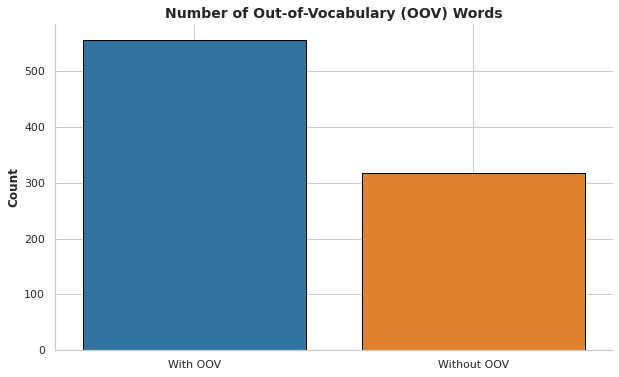

In [47]:
import matplotlib.pyplot as plt
import seaborn as sns

# Improving plot aesthetics using Seaborn
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting data with edgecolor and custom colors
ax = sns.barplot(x=['With OOV', 'Without OOV'], y=[len(oov_words), len(simlex_no_oov)], palette=["#1f77b4", "#ff7f0e"], ax=ax, edgecolor='black')

# Adding title and labels
ax.set_title('Number of Out-of-Vocabulary (OOV) Words', fontsize=14, fontweight='bold')
ax.set_ylabel('Count', fontsize=12, fontweight='bold')

# Adding a grid
ax.grid(True)

# Remove top and right borders
sns.despine()

plt.show()


### Code for getting layer-wise similarity, all layers, without subtokenized words (OOV):

In [50]:
def get_word_embedding(word, layer_nums):
    # Tokenize the word into subtokens and add special tokens [CLS] and [SEP]
    subtokens = [tokenizer.cls_token] + tokenizer.tokenize(word) + [tokenizer.sep_token]
    # Convert subtokens to input IDs
    input_ids = tokenizer.convert_tokens_to_ids(subtokens)
    # Wrap it in a tensor and add an extra batch dimension
    input_ids = torch.tensor(input_ids).unsqueeze(0)
    # Make sure the model does not compute gradients
    with torch.no_grad():
        # Get the model outputs
        outputs = model(input_ids, output_hidden_states=True)
    # Check if layer_nums is a list or a single integer
    if isinstance(layer_nums, int):
        layer_nums = [layer_nums]
    # Use the hidden state from the specified layers as word embedding
    embeddings = [outputs.hidden_states[i] for i in layer_nums]
    # Average the embeddings from the specified layers
    averaged_embedding = torch.mean(torch.stack(embeddings), dim=0)
    # Ignore the first and the last token ([CLS] and [SEP])
    averaged_embedding = averaged_embedding[0, 1:-1]
    # Get the mean of the subtoken vectors to get the word vector
    word_embedding = torch.mean(averaged_embedding, dim=0)
    # Convert tensor to a numpy array
    word_embedding = word_embedding.numpy()
    return word_embedding

def calculate_similarity(word1, word2, layer_nums):
    word1_embedding = get_word_embedding(word1, layer_nums)
    word2_embedding = get_word_embedding(word2, layer_nums)
    similarity = 1 - cosine(word1_embedding, word2_embedding)
    return similarity

# Specify the layers you want to combine
layer_nums = [1, 12]

spearman_results_oov = []  # A list to store the Spearman correlations

# Calculate the Spearman correlation for each layer and each frequency group
for layer_num in range(13):  # For RobBERT base models, there are 13 layers including the output layer
    similarity_scores = []  # Initialize similarity_scores in each iteration

    for _, row in simlex_no_oov.iterrows():
        word1 = row['word1']
        word2 = row['word2']
        similarity = calculate_similarity(word1, word2, layer_num)
        similarity_scores.append(similarity)

    simlex_no_oov[f'predicted_similarity_layer_{layer_num}'] = similarity_scores
    correlation, _ = spearmanr(simlex_no_oov['SimLex999'], simlex_no_oov[f'predicted_similarity_layer_{layer_num}'])
    spearman_results_oov.append(correlation)
    print(f'Layer {layer_num} - Spearman correlation (No OOV): {correlation:.3f}')


/tmp/ipykernel_999649/2419495525.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  simlex_no_oov[f'predicted_similarity_layer_{layer_num}'] = similarity_scores


Layer 0 - Spearman correlation (No OOV): 0.461
Layer 1 - Spearman correlation (No OOV): 0.401
Layer 2 - Spearman correlation (No OOV): 0.362
Layer 3 - Spearman correlation (No OOV): 0.336
Layer 4 - Spearman correlation (No OOV): 0.330
Layer 5 - Spearman correlation (No OOV): 0.346
Layer 6 - Spearman correlation (No OOV): 0.336
Layer 7 - Spearman correlation (No OOV): 0.326
Layer 8 - Spearman correlation (No OOV): 0.317
Layer 9 - Spearman correlation (No OOV): 0.305
Layer 10 - Spearman correlation (No OOV): 0.276
Layer 11 - Spearman correlation (No OOV): 0.206
Layer 12 - Spearman correlation (No OOV): 0.197


#### Visualize in blue colour scheme

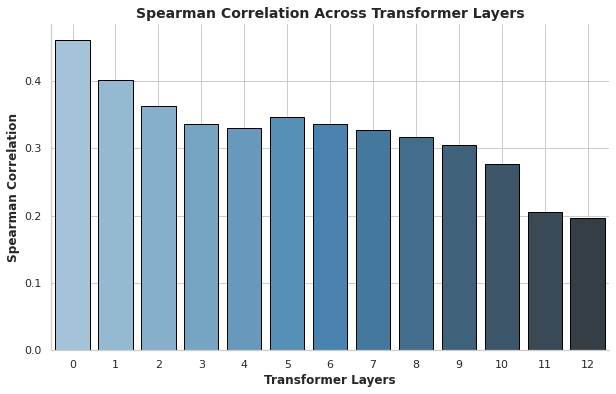

In [51]:
import torch
from scipy.spatial.distance import cosine
from scipy.stats import spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

# Plotting
sns.set(style="whitegrid")
fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x=list(range(13)), y=spearman_results_oov, palette="Blues_d", ax=ax, edgecolor='black')
ax.set_title('Spearman Correlation Across Transformer Layers', fontsize=14, fontweight='bold')
ax.set_xlabel('Transformer Layers', fontsize=12, fontweight='bold')
ax.set_ylabel('Spearman Correlation', fontsize=12, fontweight='bold')
ax.grid(True)
sns.despine()
plt.show()

#### POS-based analysis of the above

In [52]:
pos_categories = ["A", "N", "V"]
for pos in pos_categories:
    pos_data = simlex_no_oov[simlex['POS'] == pos]
    spearman_corr = pos_data['SimLex999'].corr(pos_data['predicted_similarity_layer_0'], method='spearman')
    print(f"Spearman correlation for {pos}: {spearman_corr}")


Spearman correlation for A: 0.43204140136362396
Spearman correlation for N: 0.482378898976001
Spearman correlation for V: 0.0703531370461269


/tmp/ipykernel_999649/930490011.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  pos_data = simlex_no_oov[simlex['POS'] == pos]


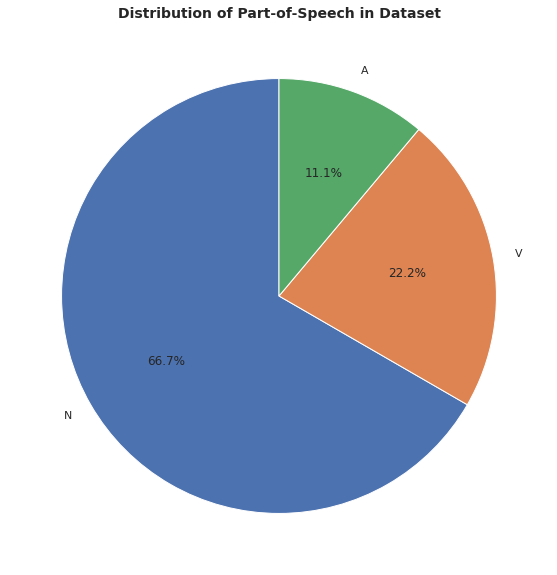

In [53]:
import matplotlib.pyplot as plt

# Calculate POS frequencies
pos_counts = simlex['POS'].value_counts()

# Plot a pie chart
plt.figure(figsize=(10,10))
plt.pie(pos_counts, labels=pos_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Part-of-Speech in Dataset', fontsize=14, fontweight='bold')
plt.show()
